# Particle Images: Electron vs Photon Classification
## Stephen D. Butalla & Mehdi Rahmani
### 2021/11/22

This Jupyter Notebook contains our solutions to the Particle Images: Electron vs Photon Classification challenge for the 2021 Machine Learning for Science (ML4SCI) Hackathon.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelBinarizer

plt.rcParams.update({'font.size': 22})

In [2]:
def loadData():
    electronFile = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5" 
    elData = h5py.File(electronFile, "r") # Load electron images file
    elX = elData["X"] # Get images
    elY = elData["y"] # Get labels


    photonFile = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
    gammaData = h5py.File(photonFile, "r") # Load photon images file
    gammaX = gammaData["X"] # Get images
    gammaY = gammaData["y"] # Get labels
    
    # Combine data to single dataset
    allDataX = np.concatenate((elX, gammaX), axis=0)
    allDataY = np.concatenate((elY, gammaY), axis=0)
    
    return elX, gammaX, allDataX, allDataY

In [4]:
elX, gammaX, allDataX, allDataY = loadData()

In [33]:
print("Data shapes\nImage dataset: {}\nLabels: {}".format(allDataX.shape, allDataY.shape))

Data shapes
Image dataset: (498000, 32, 32, 2)
Labels: (498000,)


In [29]:
elData.shape

(249000, 32, 32)

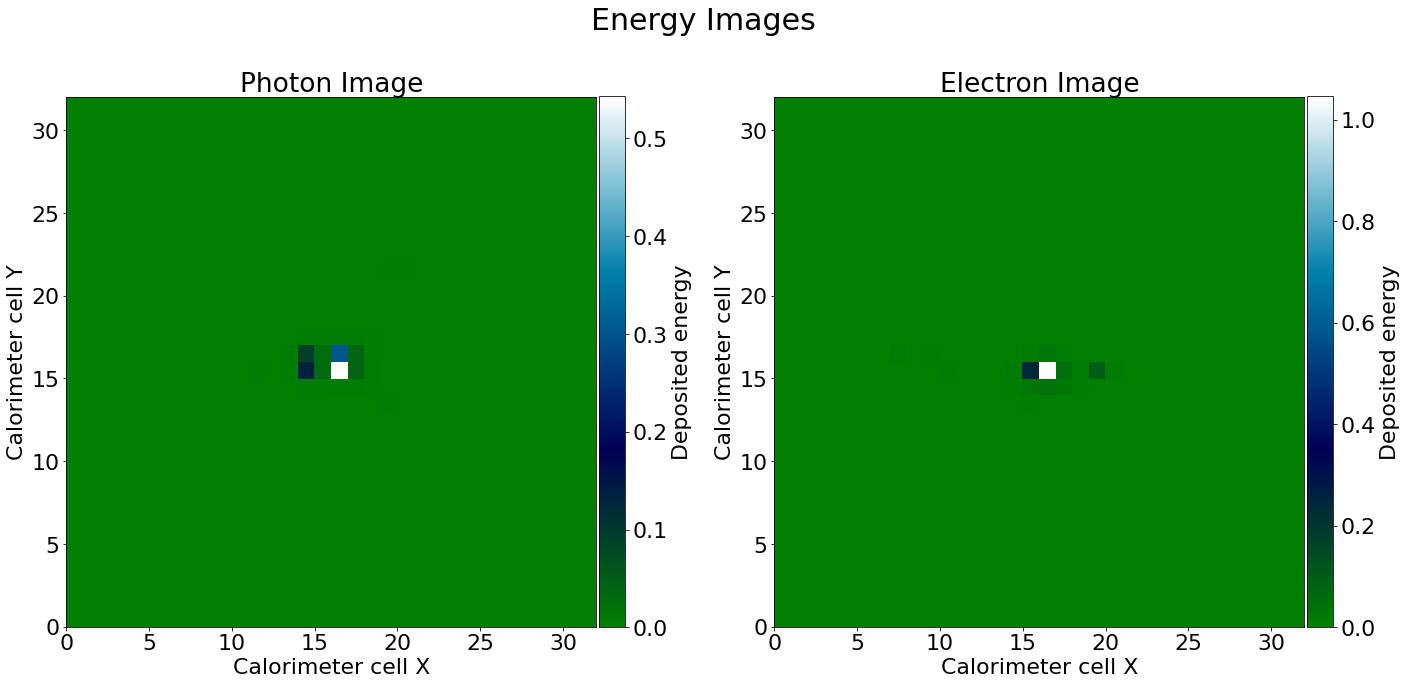

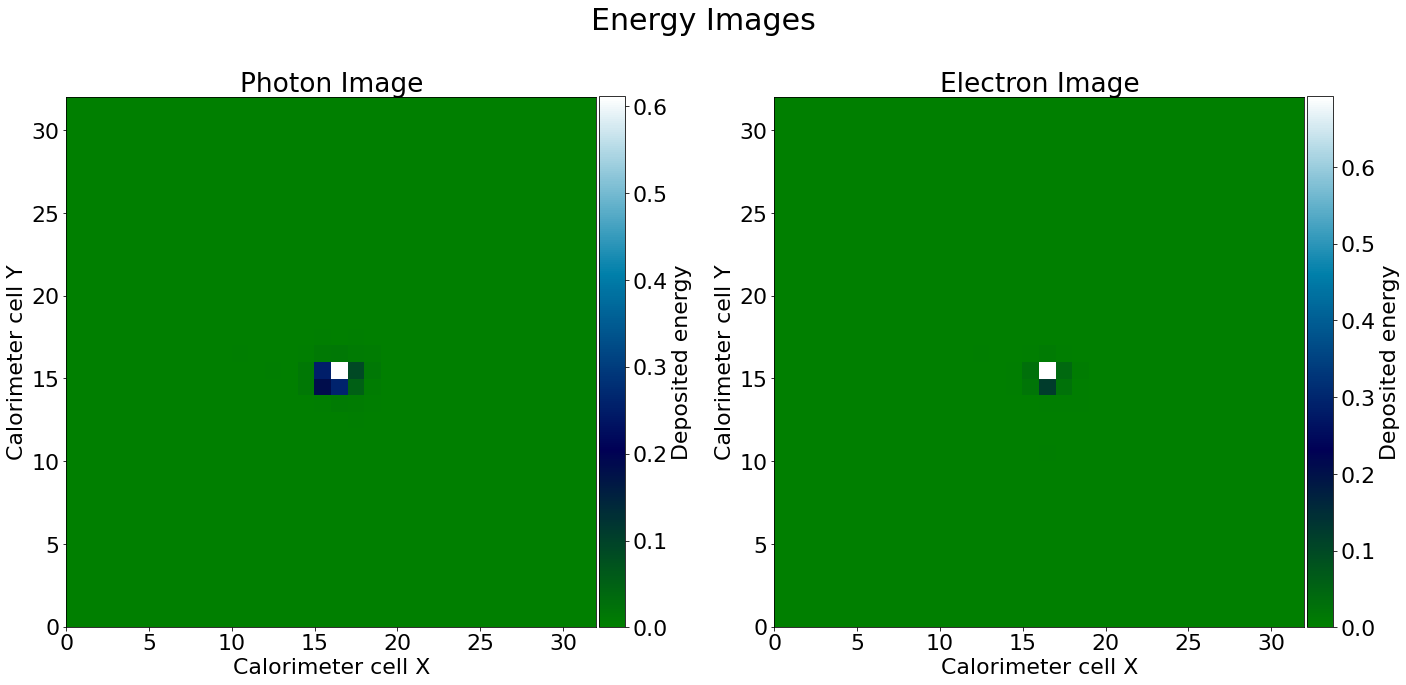

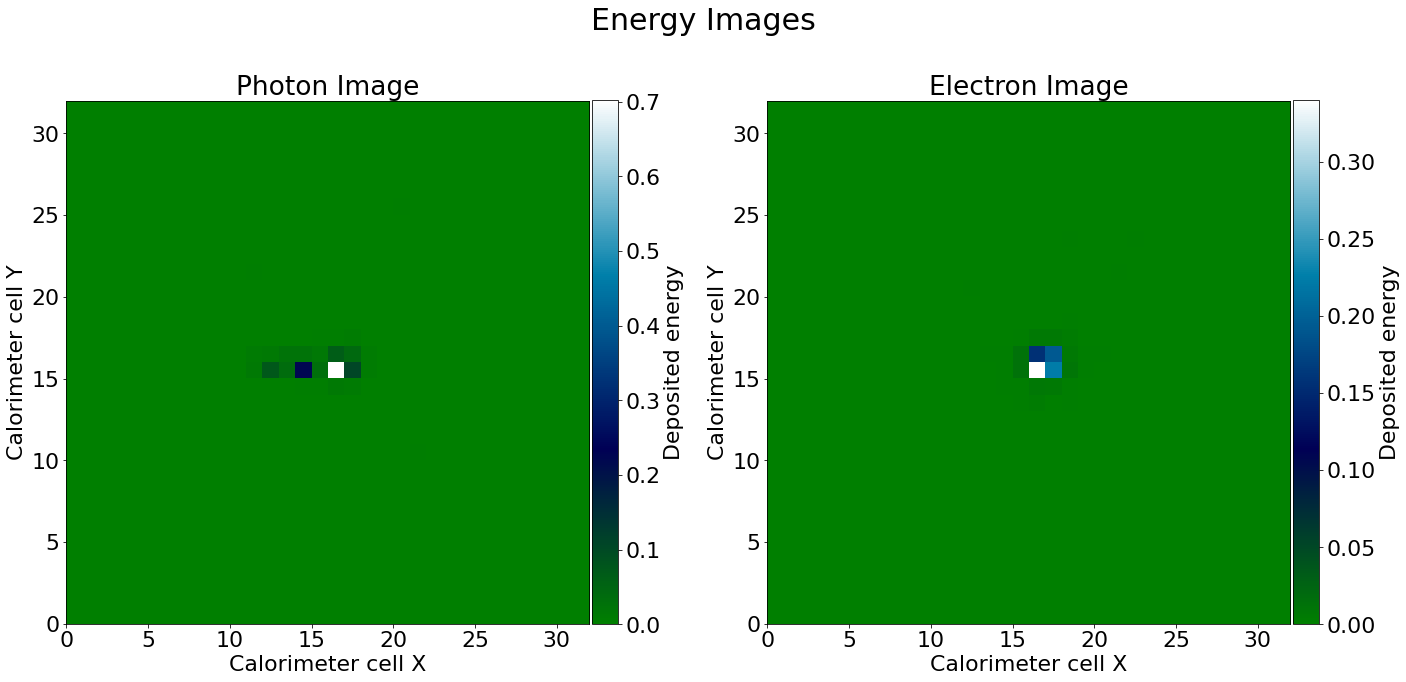

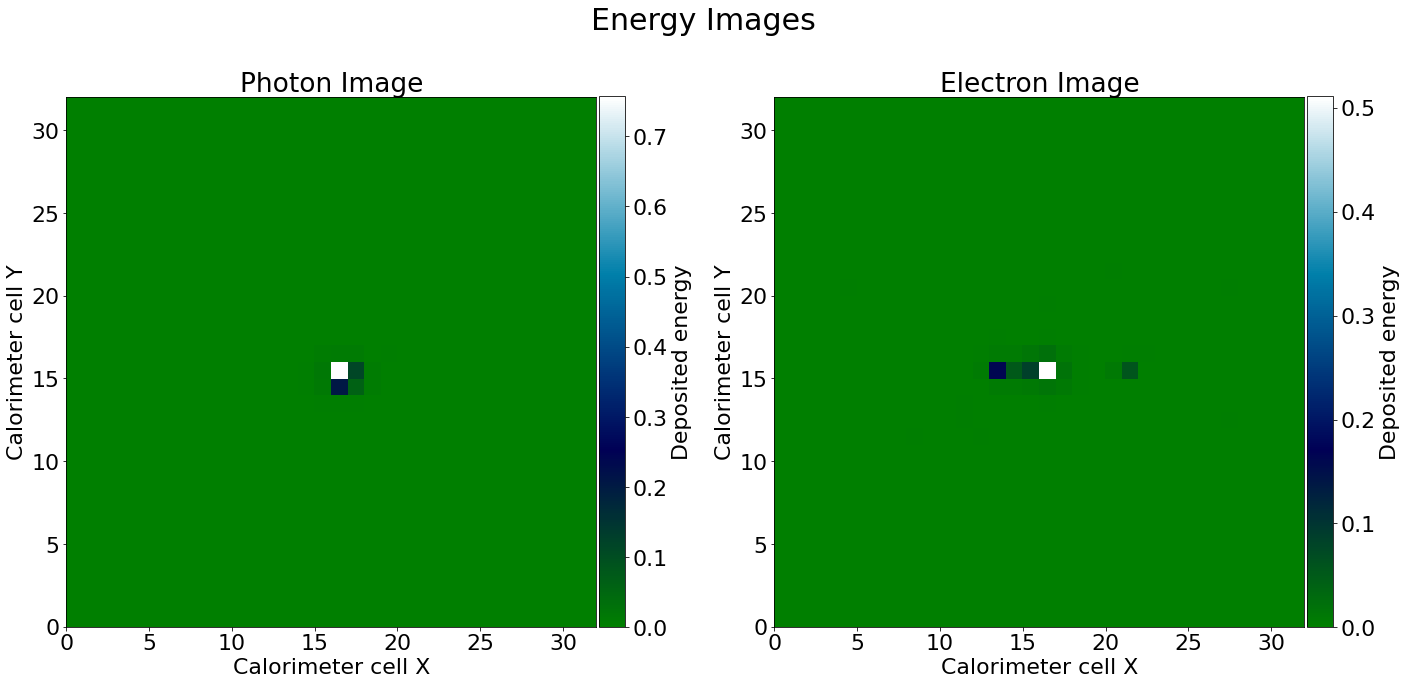

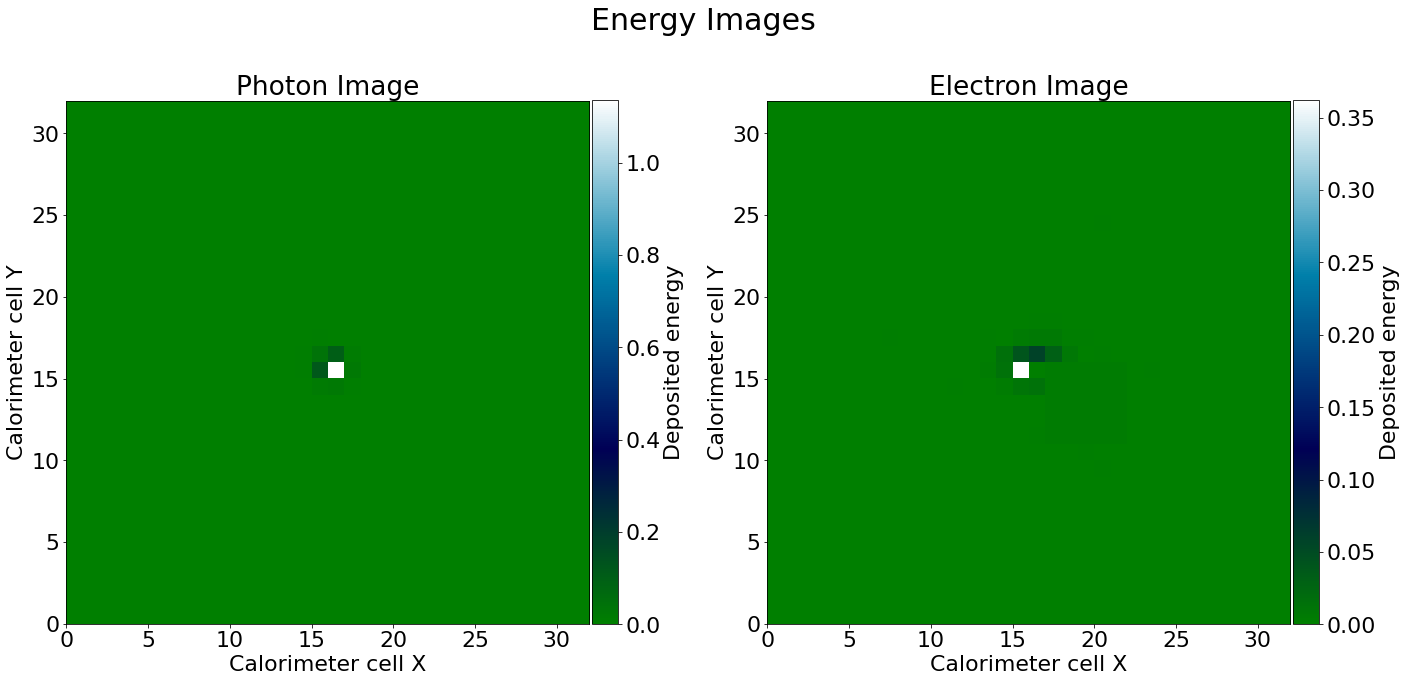

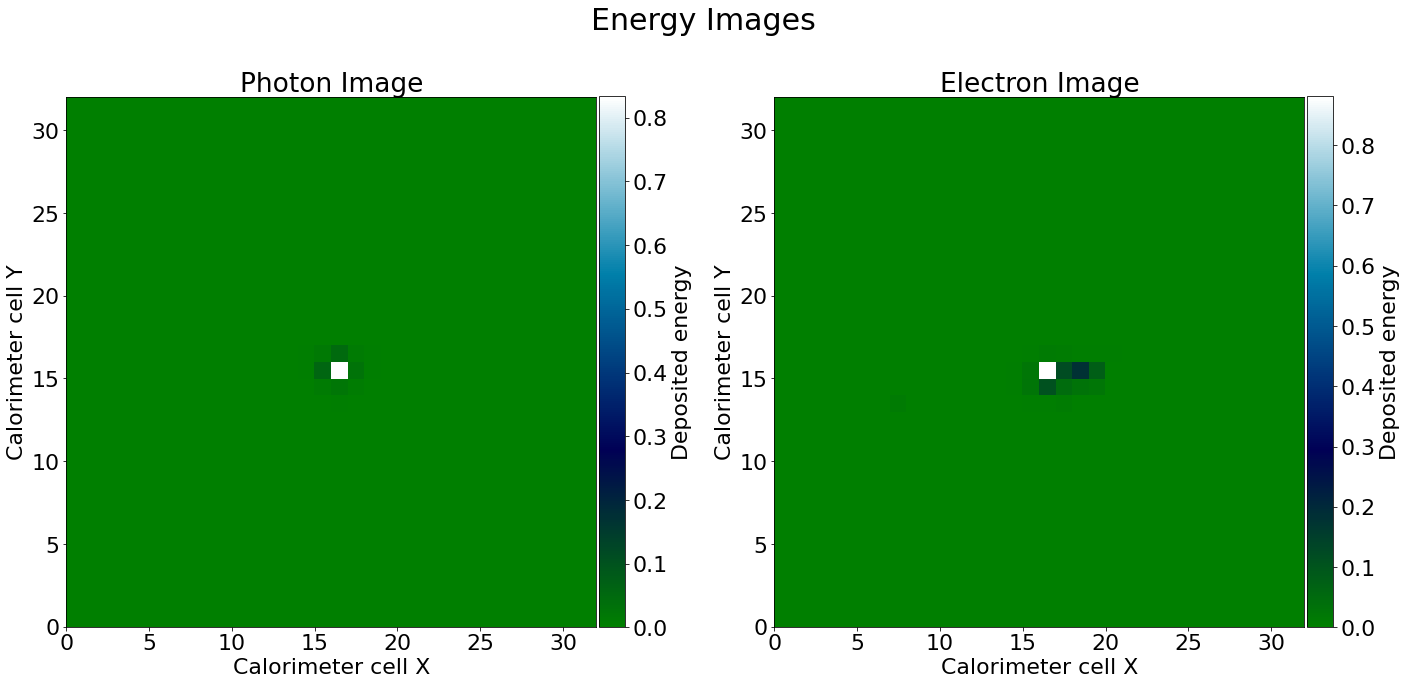

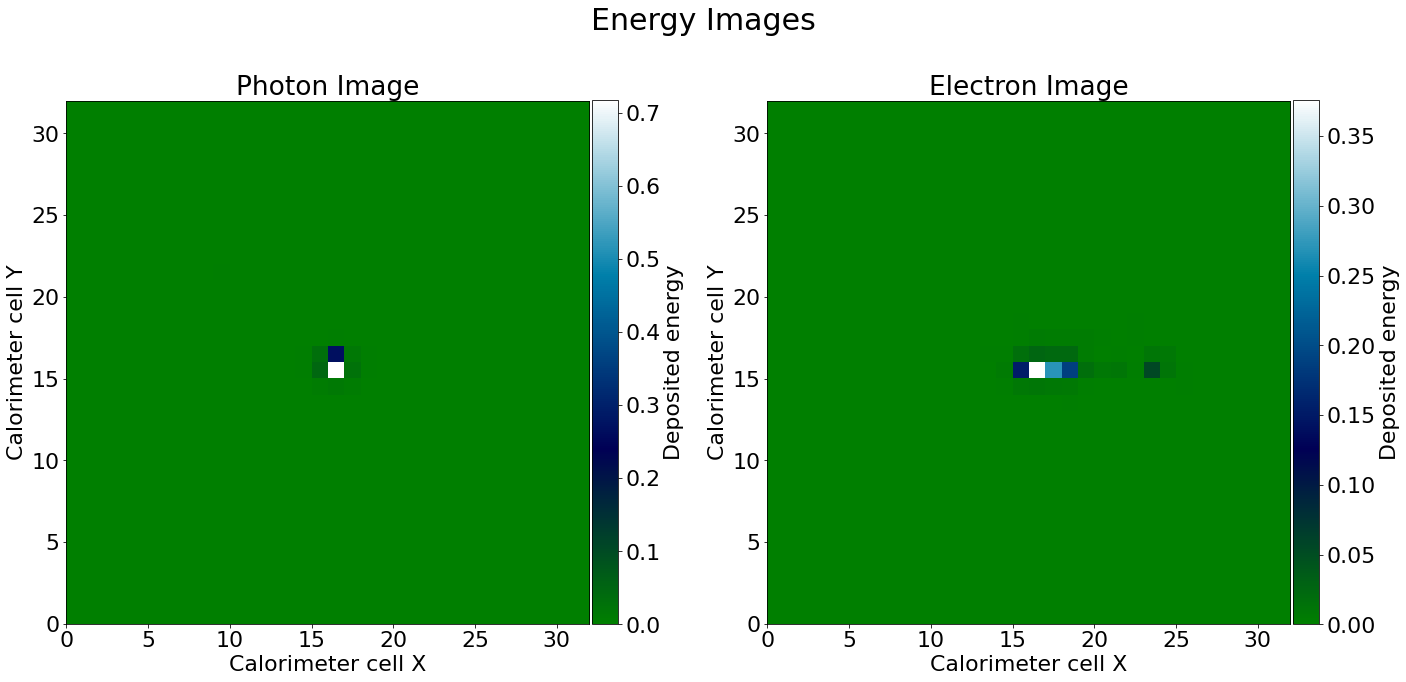

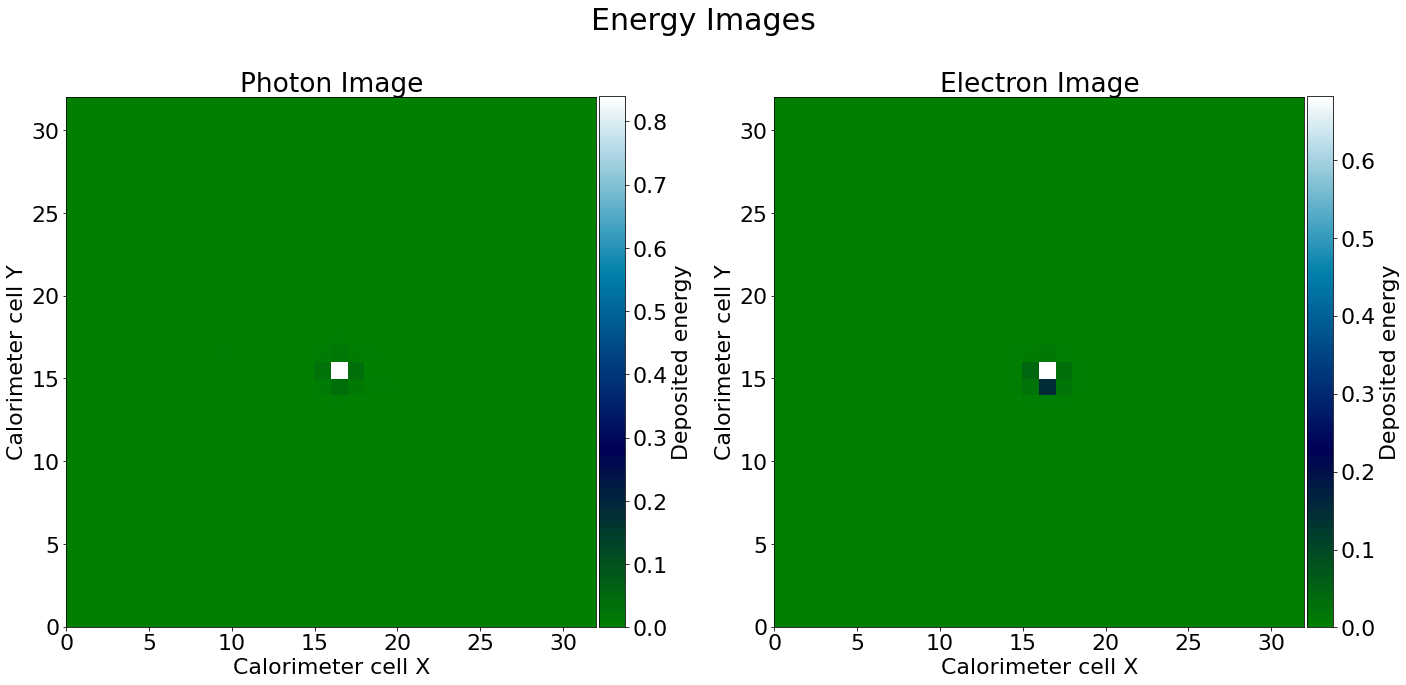

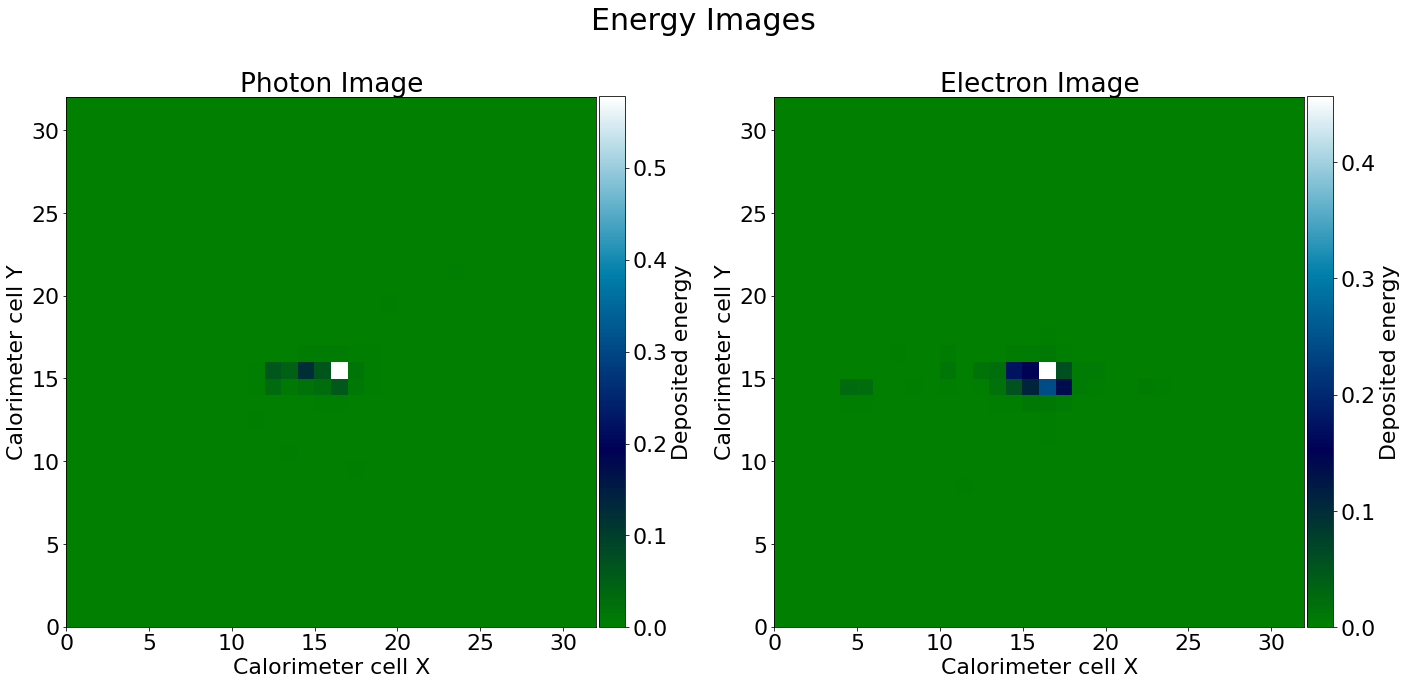

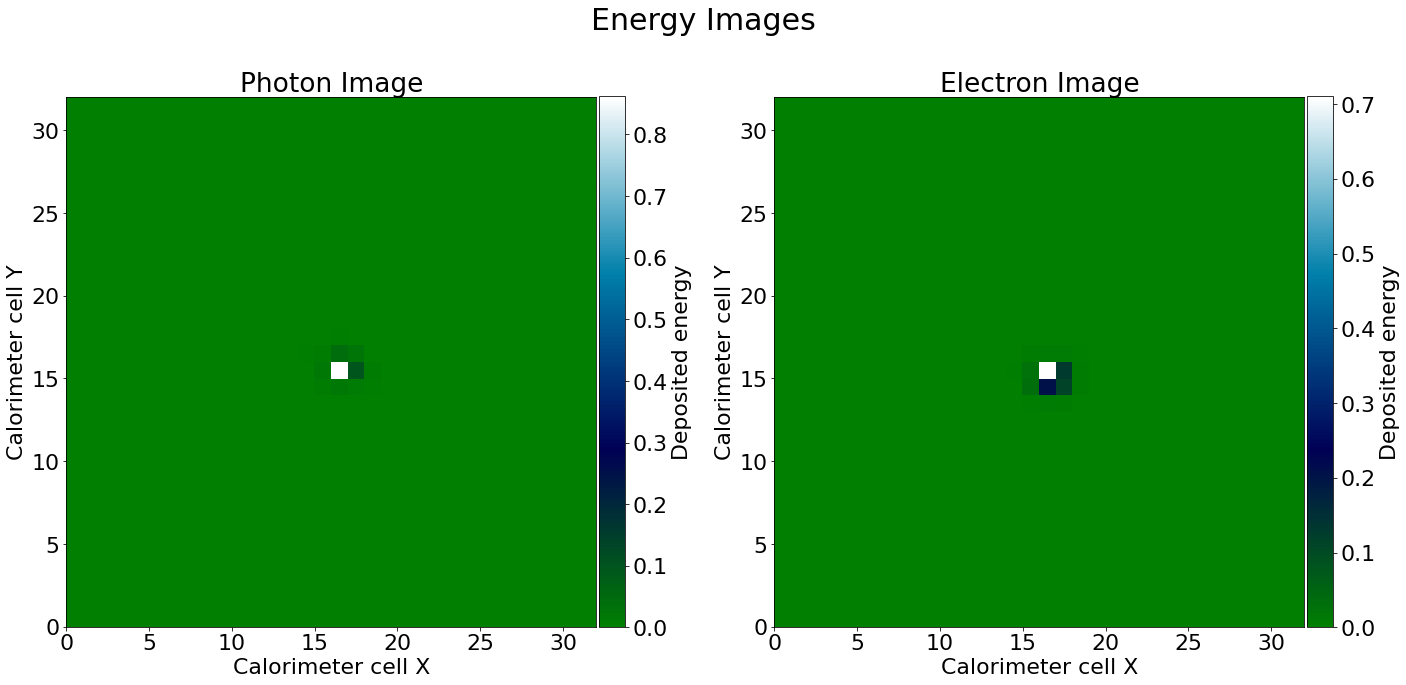

In [34]:
# Display subset of energy images
for im in range(0,10):
    fig, ax = plt.subplots(1, 2, figsize=(20,20))
    im0 = ax[0].imshow(gammaX[im,:,:,0], interpolation='nearest', extent=[0, 32, 0, 32], cmap=cm.ocean)
    cbar0 = plt.colorbar(im0, fraction=0.0475, pad=0.0048, ax=ax[0])
    cbar0.set_label('Deposited energy',labelpad=4)
    ax[0].set_xlabel(r'Calorimeter cell X')
    ax[0].set_ylabel(r'Calorimeter cell Y')
    ax[0].set_title('Photon Image')


    im1 = ax[1].imshow(elX[im,:,:, 0], interpolation='nearest', extent=[0, 32, 0, 32], cmap=cm.ocean)
    cbar1 = plt.colorbar(im1, fraction=0.0475, pad=0.0048, ax=ax[1])
    cbar1.set_label('Deposited energy', labelpad=4)
    ax[1].set_xlabel(r'Calorimeter cell X')
    ax[1].set_ylabel(r'Calorimeter cell Y')
    ax[1].set_title('Electron Image')

    fig.suptitle('Energy Images', fontsize = 30)
    fig.tight_layout()
    fig.subplots_adjust(top=1.45)

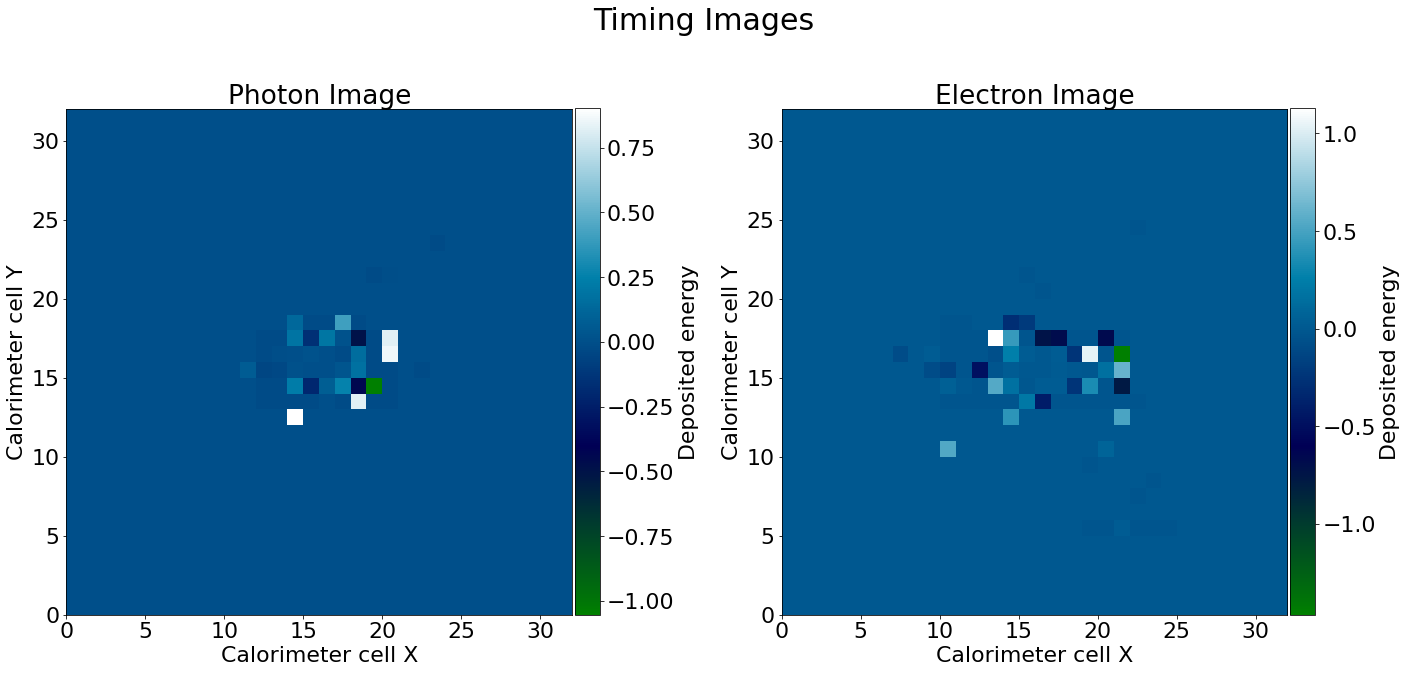

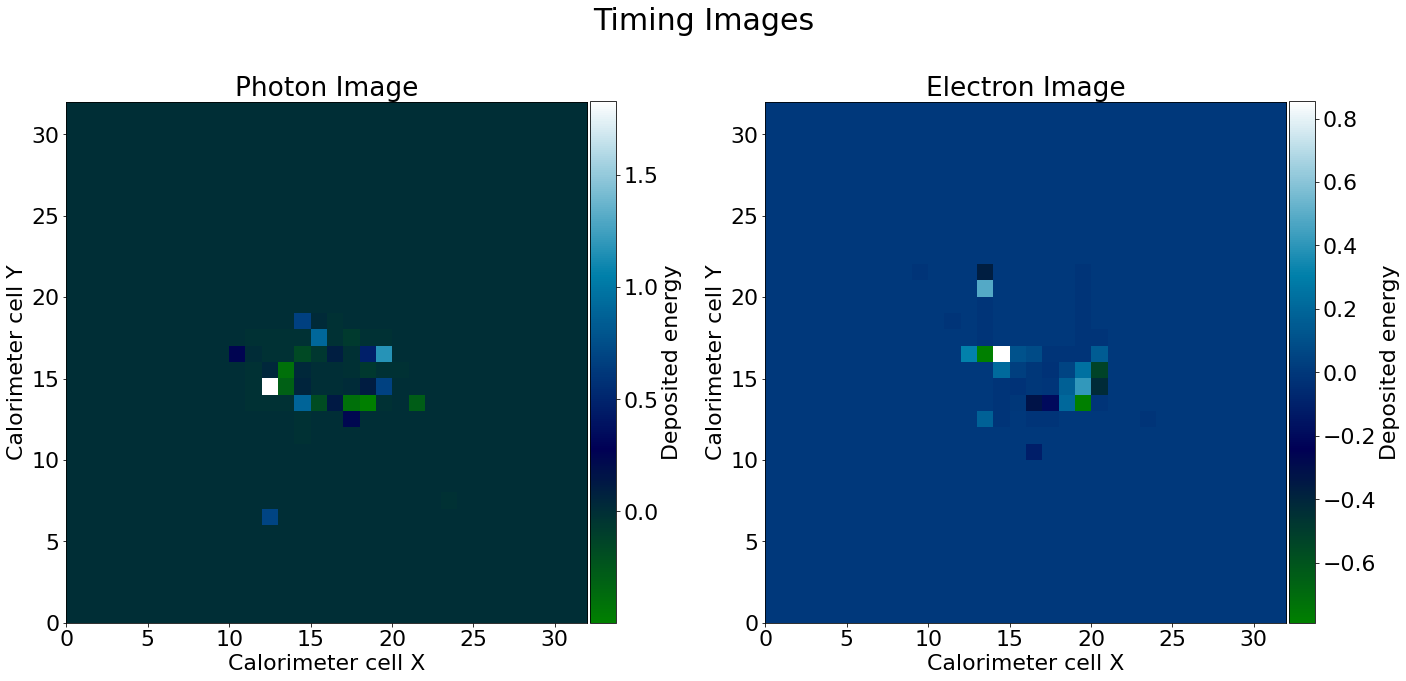

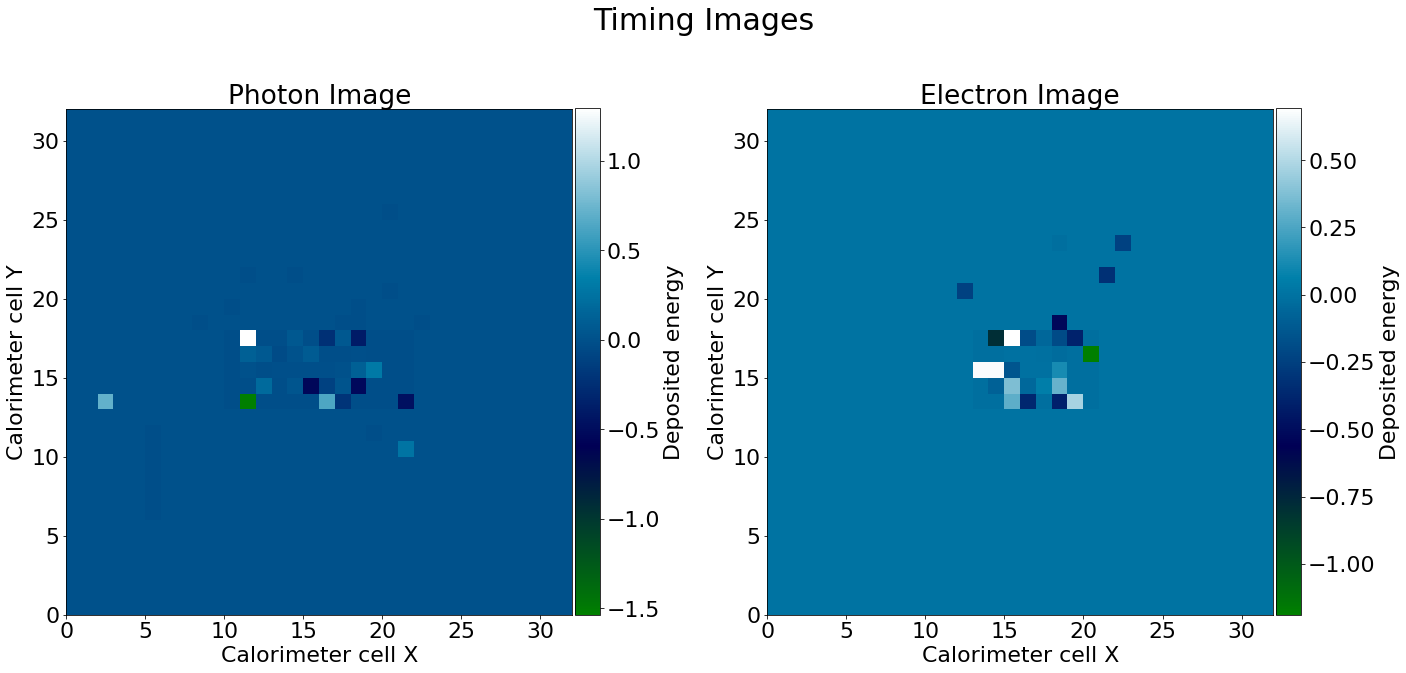

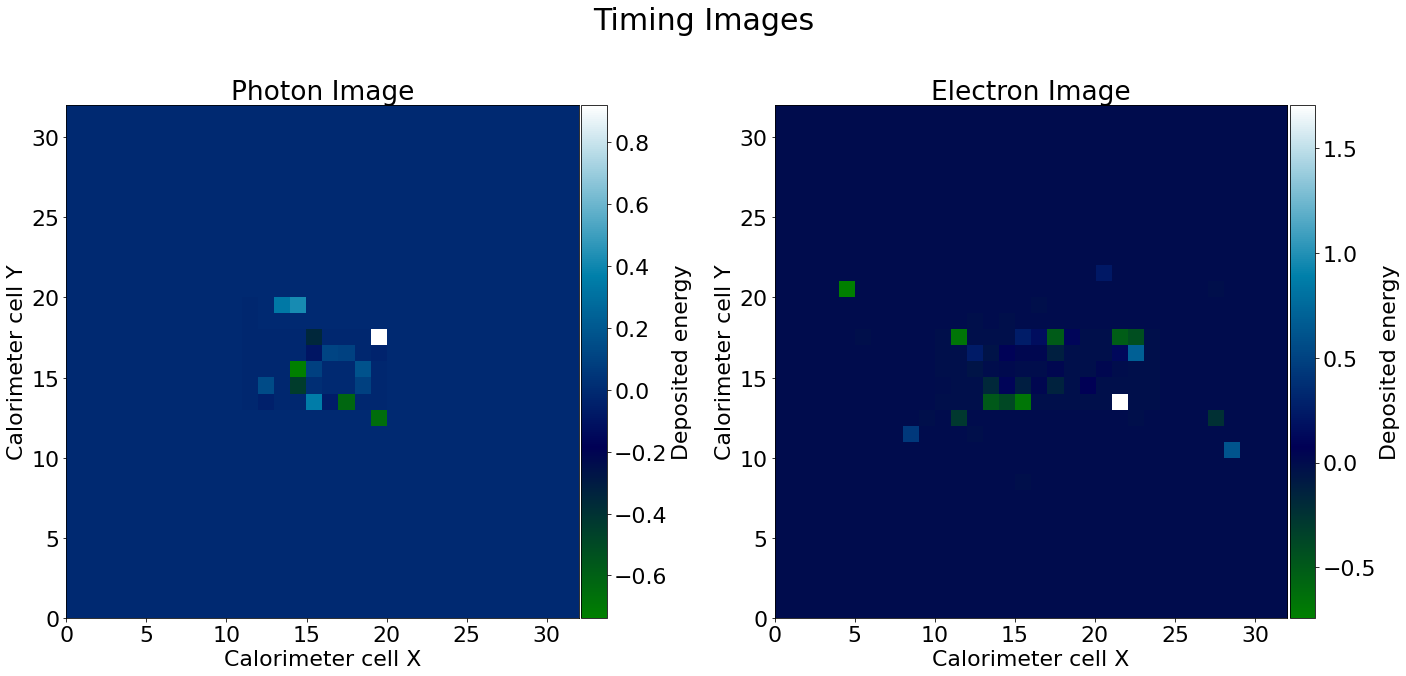

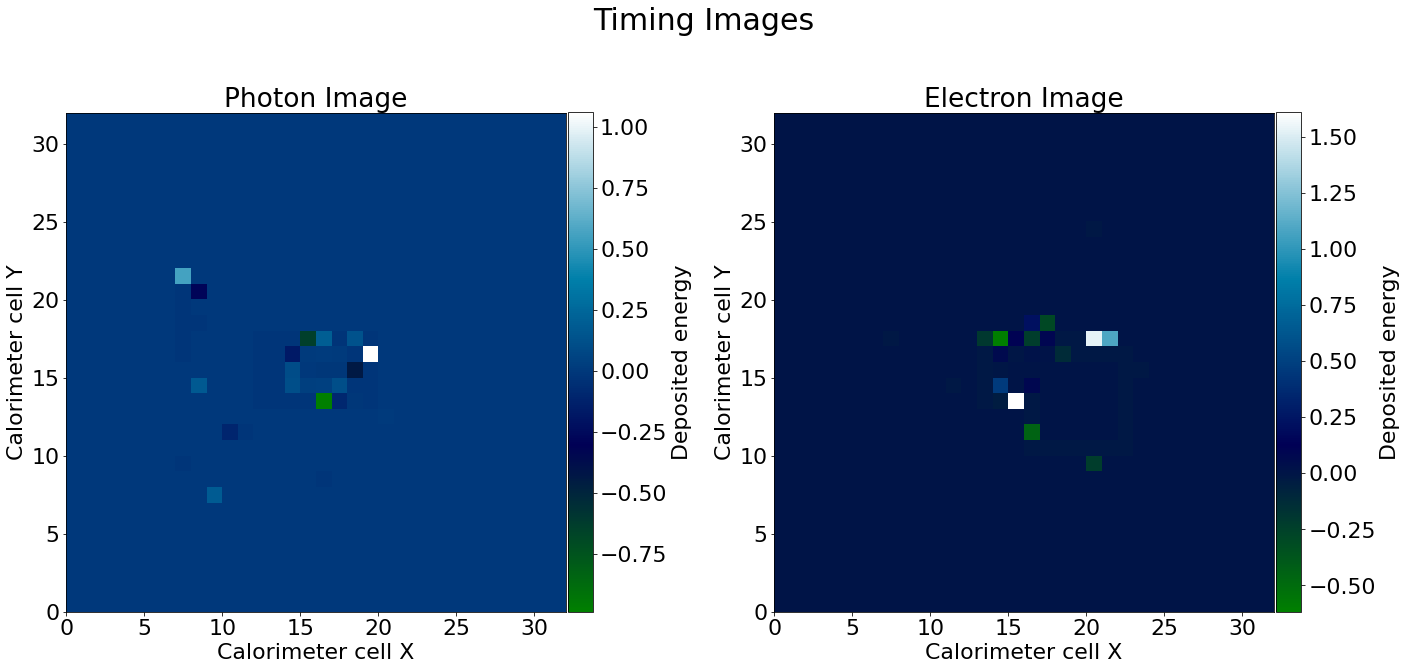

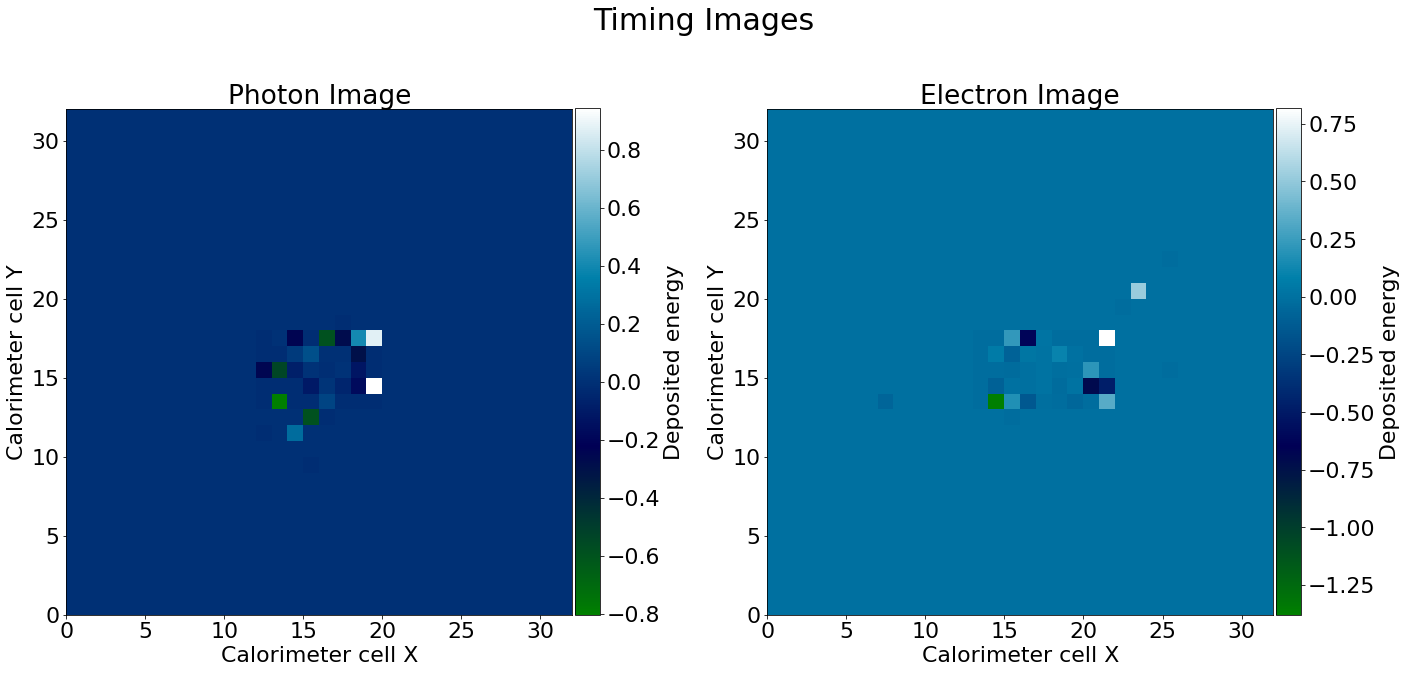

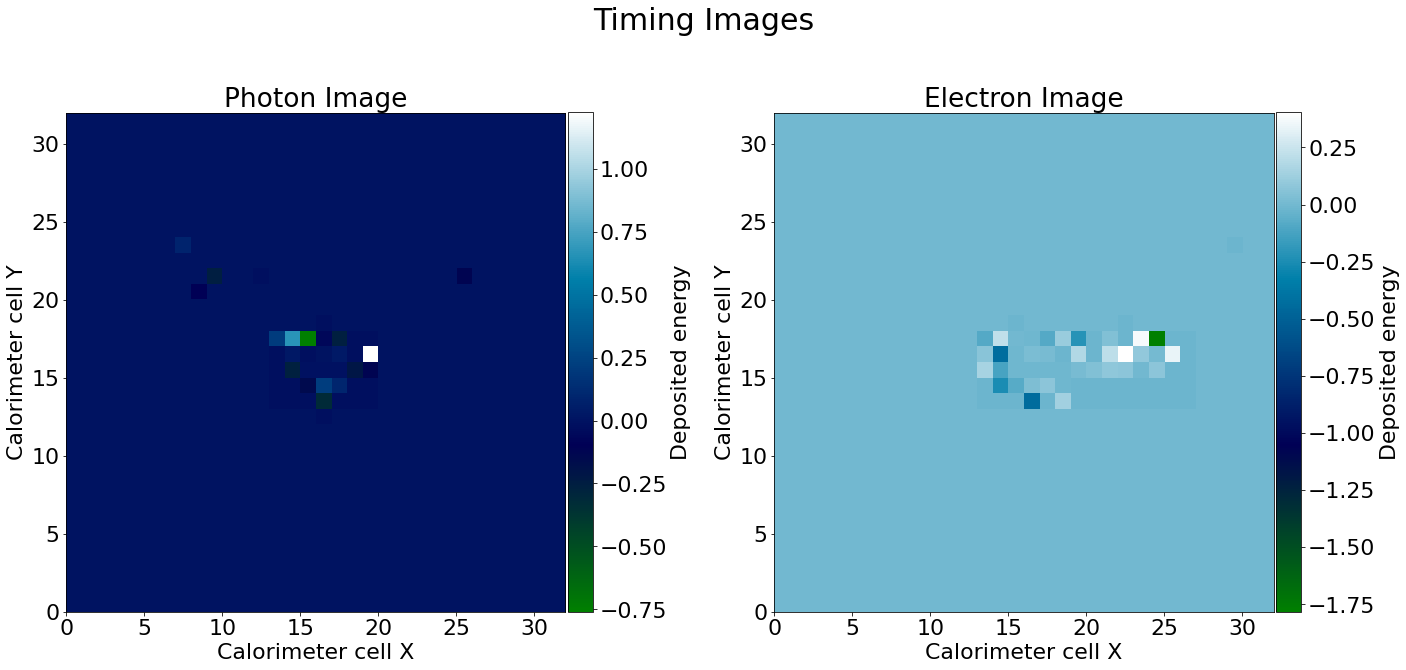

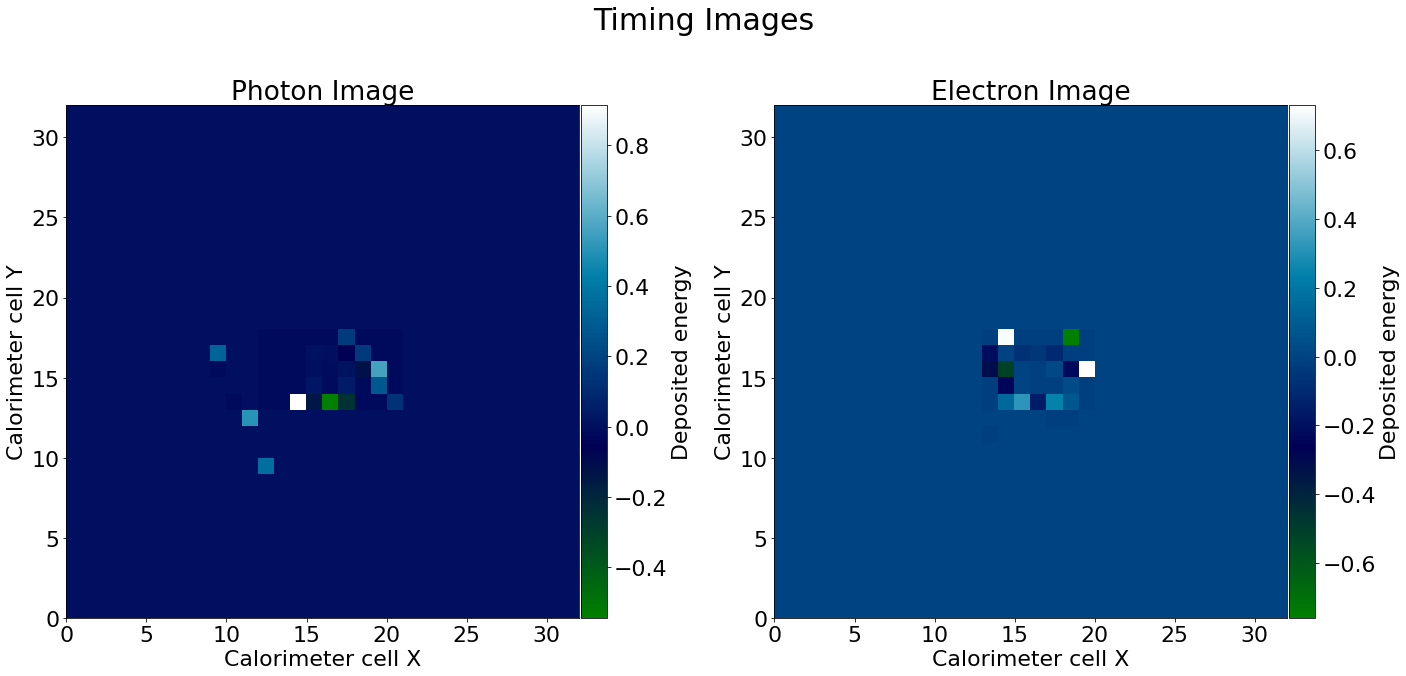

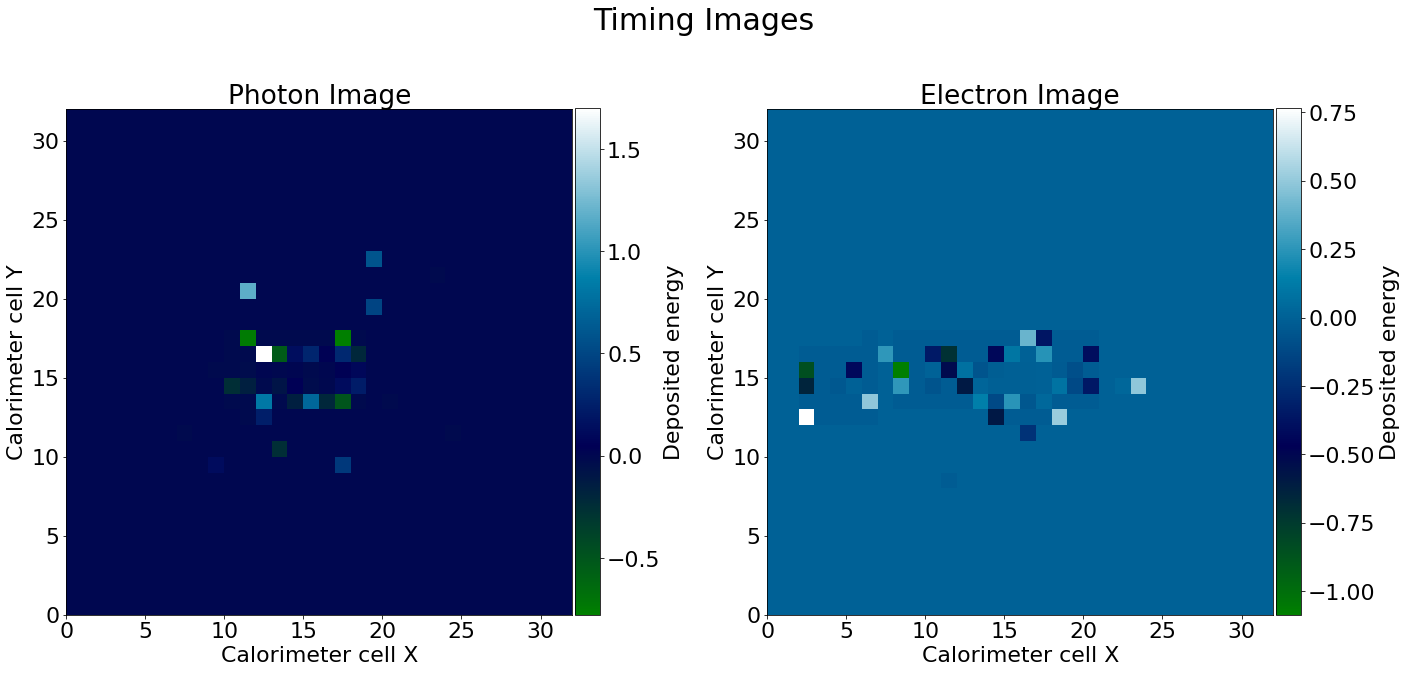

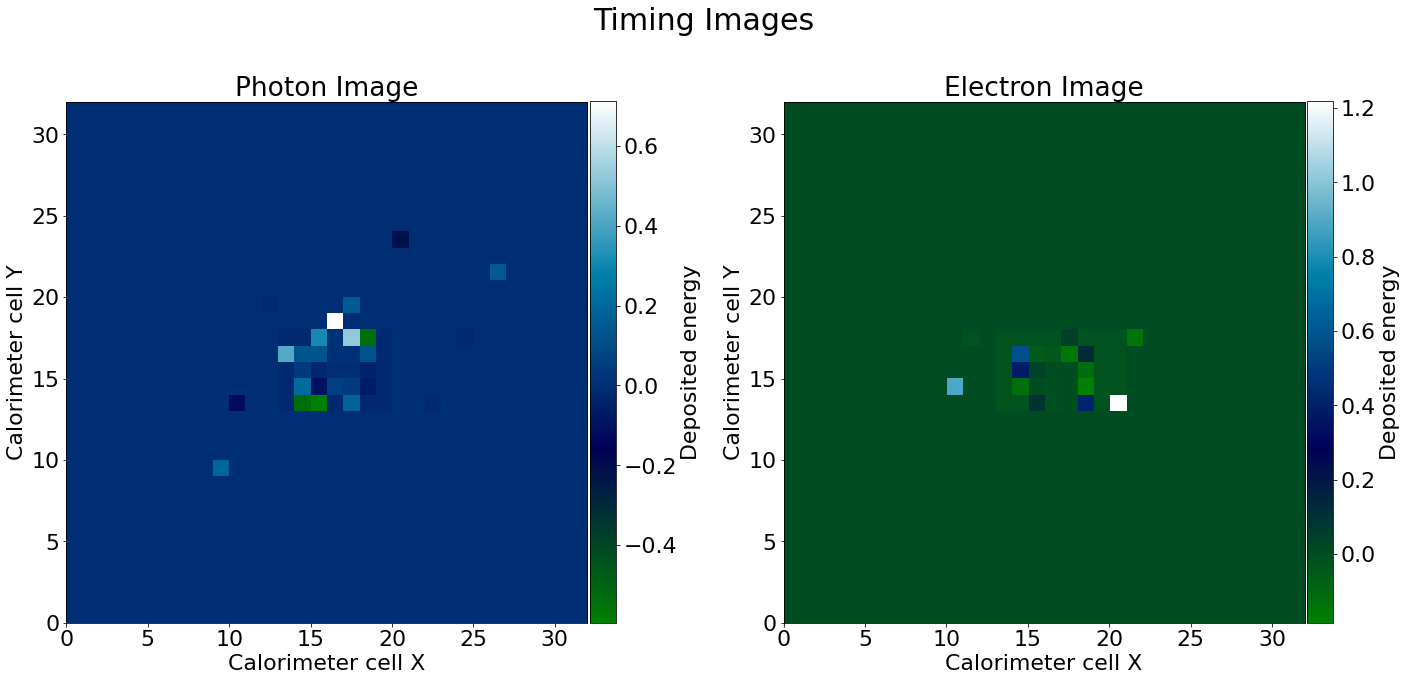

In [5]:
# Display subset of timing images
for im in range(0,10):
    fig, ax = plt.subplots(1, 2, figsize=(20,20))
    im0 = ax[0].imshow(gammaX[im,:,:,1], interpolation='nearest', extent=[0, 32, 0, 32], cmap=cm.ocean)
    cbar0 = plt.colorbar(im0, fraction=0.0475, pad=0.0048, ax=ax[0])
    cbar0.set_label('Deposited energy',labelpad=4)
    ax[0].set_xlabel(r'Calorimeter cell X')
    ax[0].set_ylabel(r'Calorimeter cell Y')
    ax[0].set_title('Photon Image')


    im1 = ax[1].imshow(elX[im,:,:, 1], interpolation='nearest', extent=[0, 32, 0, 32], cmap=cm.ocean)
    cbar1 = plt.colorbar(im1, fraction=0.0475, pad=0.0048, ax=ax[1])
    cbar1.set_label('Deposited energy', labelpad=4)
    ax[1].set_xlabel(r'Calorimeter cell X')
    ax[1].set_ylabel(r'Calorimeter cell Y')
    ax[1].set_title('Electron Image')

    fig.suptitle('Timing Images', fontsize = 30)
    fig.tight_layout()
    fig.subplots_adjust(top=1.45)

In [36]:
energyDataX = allDataX[:,:,:,0]
energyDataY = allDataY[:]
energyDataX = energyDataX.reshape(energyDataX.shape[0], energyDataX.shape[1], energyDataX.shape[1], 1)

In [83]:
def metrics(textX, testY, model):
    predY     = model.predict(testX)
    predYtemp = predY.ravel()
    falsePR, truePR, thresh = roc_curve(testY, predYtemp)
    aucVal = auc(falsePR, truePR)
    
    predYformatted = np.where(predY[:,0] > 0.5, 1, 0) # Format output probabilitities to binarhy category for classification report
    print(classification_report(testY, predYformatted))

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(falsePR, truePR, label='AUC = {:.3f}'.format(aucVal))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.legend(loc='best')
    plt.show()   
    fig.savefig('roc_auc.png')
    
    return truePR, falsePR, aucVal

def plotHistory(result, epochNum):
    fig, ax = plt.subplots(figsize = (10,10))
    ax.grid()
    ax.plot(np.arange(0, epochNum), result.history["loss"], label="train_loss")
    ax.plot(np.arange(0, epochNum), result.history["val_loss"], label="val_loss")
    ax.plot(np.arange(0, epochNum), result.history["accuracy"], label="train_acc")
    ax.plot(np.arange(0, epochNum), result.history["val_accuracy"], label="val_acc")
    ax.set_title("Training loss and accuracy")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel("Loss/Accuracy")
    ax.legend(loc="best")

In [87]:
(trainX, testX, trainY, testY) = train_test_split(energyDataX, energyDataY, test_size = 0.20, random_state = 1)

In [46]:
print('Train and test dataset shapes:\nTrain X: {}\nTrain Y: {}\nTest X: {}\nTest Y: {}'.format(trainX.shape, trainY.shape, testX.shape, testY.shape))

Train and test dataset shapes:
Train X: (398400, 32, 32, 1)
Train Y: (398400,)
Test X: (99600, 32, 32, 1)
Test Y: (99600,)


In [39]:
def CNN_model(dim0, dim1, depth, alphaSched = False):
    # create model
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', kernel_initializer='glorot_uniform', input_shape=(dim0, dim1, depth)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size=(3, 3), activation="relu", kernel_initializer='glorot_uniform'))
    model.add(Conv2D(filters = 64, kernel_size=(3, 3), activation="relu", kernel_initializer='glorot_uniform'))
    model.add(Conv2D(filters = 32, kernel_size=(3, 3), activation="relu", kernel_initializer='glorot_uniform'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [40]:
model = CNN_model(32,32,1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          1

In [48]:
reduLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.000001, verbose=1)

results =  model.fit(trainX, trainY, validation_split=0.2, epochs=30, callbacks=[reduLR])

Epoch 1/30
9960/9960 [==============================] - 705s 71ms/step - loss: 0.5920 - accuracy: 0.6934 - val_loss: 0.6881 - val_accuracy: 0.5627
Epoch 2/30
9960/9960 [==============================] - 707s 71ms/step - loss: 0.5673 - accuracy: 0.7165 - val_loss: 0.7198 - val_accuracy: 0.5492
Epoch 3/30
9960/9960 [==============================] - 615s 62ms/step - loss: 0.5615 - accuracy: 0.7208 - val_loss: 0.6227 - val_accuracy: 0.6475
Epoch 4/30
9960/9960 [==============================] - 604s 61ms/step - loss: 0.5578 - accuracy: 0.7240 - val_loss: 0.6530 - val_accuracy: 0.6295
Epoch 5/30
9960/9960 [==============================] - 588s 59ms/step - loss: 0.5550 - accuracy: 0.7255 - val_loss: 0.7362 - val_accuracy: 0.5575

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/30
9960/9960 [==============================] - 593s 60ms/step - loss: 0.5396 - accuracy: 0.7360 - val_loss: 0.5449 - val_accuracy: 0.7303
Epoch 7/30
9960/9960 [==============

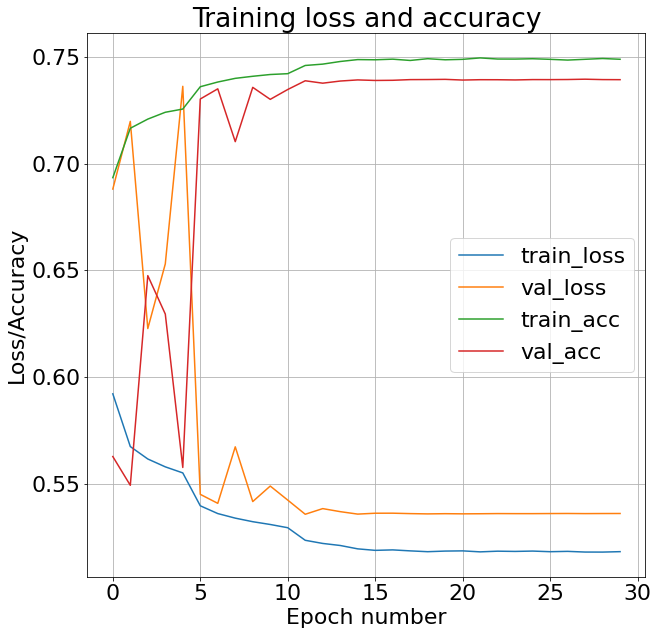

In [84]:
plotHistory(results, 30)

              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73     49702
         1.0       0.73      0.76      0.74     49898

    accuracy                           0.74     99600
   macro avg       0.74      0.74      0.74     99600
weighted avg       0.74      0.74      0.74     99600



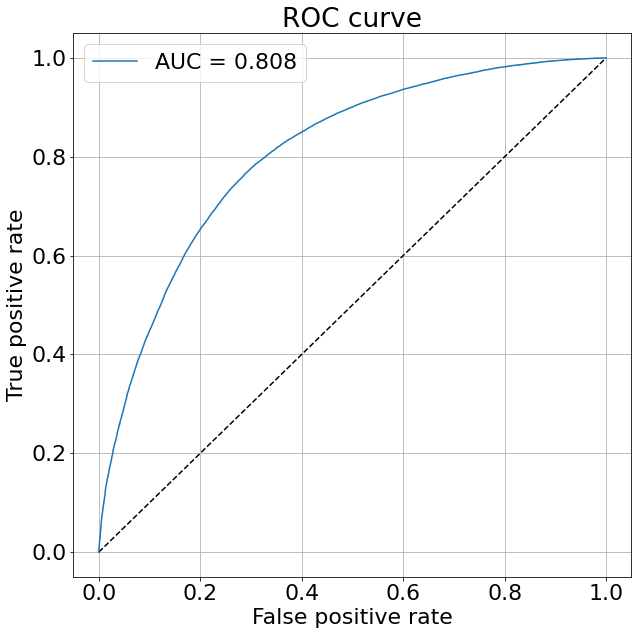

In [89]:
truePR, falsePR, aucVal = metrics(testX, testY, model)

## Discussion
Of the many architectures and preprocessing methods tested tested, the model defined by `CNN_model()` returned the best performance, with a final test accuracy of 74% and an area under the curve (AUC) of 0.808. The model (with optimizer state and weights) is saved in the `imageClass_model_SB-MH/` directory.